# Quarterly QA on Siemens Scanners

This is performed on the Siemens "long bottle" phantom in the most used head coil - either the standard Head and Neck 25 element coil or the 32 channel head coil. These are used for the Siemens coil QA and it can be easily and reproducibly positioned using the dedicated Siemens foam pad.

Where this phantom is not available (eg on Avanto generation systems) then the slightly wider "short bottle" and its corresponding holder should be used. This variant may be specified in the analysis below.

The bandwidth used should be approximately scaled with the field strength so 130Hz at 1.5T and 260Hz at 3.0T.

The quarterly QA scans consist of the following scans:
 - SE, 2 acquisitions, with/without PSN, multiple elements, RMS coil combine -> SNR, Unif, XY gradient scale
 - SE, 2 acquisitions, without PSN, multiple elements, RMS coil combine, TX switched off by setting reference voltages to zero

and optionally:
 - EPI, 60+ acquisitions, ghosting and long term stability, eddy currents and shim (distortion)

The acquisitions should have the following labels in the protocol to make them easier to identify:
 - `QQA_SE_SIGNAL`
 - `QQA_SE_NOISE`
 - `QQA_EPI_STABILITY`
 
Although we may well have multiple series for each label we should be able to deduce which is which based on the image type, coil names and coil element masks.

In [1]:
from __future__ import division, print_function

# Patient details file yaml/json
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd

def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from mriqa.phantoms import PHILIPS1L5BOTTLE
from mriqa.dcmio import fetch_series, coil_elements
from mriqa.tools import show_montage

from dcmextras.siemenscsa import csa, phoenix

from mriqa.reports import (
    ghosting_report, uniformity_report, noise_correlation_report,
    circularity_report, snr_report_multi
)

# Watermark

from platform import node, python_implementation, python_version, system, release
from datetime import datetime, timezone, timedelta
from time import time
from getpass import getuser

iso_dt = datetime.fromtimestamp(
    int(time()),
    timezone.utc
).astimezone().isoformat()
    
def package_versions(packages):
    versions = {}
    for package in packages:
        try:
            imported = __import__(package)
        except ImportError:
            versions[package] = 'not installed'
        else:
            versions[package] = imported.__version__
    return versions

watermark = {
    'CalculationTime': iso_dt,
    'User': '%s/%s' % (node(), getuser()),
    'PythonVersion':  '%s %s' % (python_implementation(), python_version()),
    'Platform': '%s %s' % (system(), release())
}
watermark.update(
    package_versions(['mriqa', 'dcmextras', 'pydicom', 'scipy', 'numpy', 'skimage'])
) 

display(pd.DataFrame(
    {'Watermark': list(watermark.values())},
    index=watermark.keys()
))
                 

Watermark
CalculationTime  2020-04-27T16:08:11+01:00
User                    birchhub/elberthol
PythonVersion                CPython 3.7.7
Platform           Linux 4.15.0-76-generic
mriqa                                0.2.5
dcmextras                            0.2.6
pydicom                              1.4.2
scipy                                1.4.1
numpy                               1.18.1
skimage                             0.16.2

### Details of series to analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)
patid = study_info['PatID']
studyid = study_info['StudyID']
series = study_info['Series']

phantom = PHILIPS1L5BOTTLE

d = fetch_series(patid, studyid, sernos=series['Signal_Combined'])[0]
scanner, date, operator = d.StationName, d.StudyDate, d.get('OperatorsName','BIRCH')
display(
    pd.DataFrame(
        {'Details':[scanner, date, operator, patid, studyid] + list(series.values())}, 
        index=['Scanner', 'Date', 'Operator', 'Patient', 'Study'] + list(series.keys())
    )
)

Details
Scanner             HOST-9THVNMQAOJ
Date                       20191022
Operator                           
Patient          QQA20191022NBTMR22
Study                     601130497
Signal                        [303]
Signal_Combined               [304]
Noise                          None
Noise_Combined                 None
Geometry                      [305]

# Summary

The following tests were performed as part of the quarterly checks:

- Head Coil SNR
- Phantom Circularity (distortion and scaling)
- Ghosting
- Head Coil Image Uniformity (axial only)

All of the above are acceptable.

### Recommended Actions

No actions necessary.

 

In [3]:
scandate=datetime.strptime(date, '%Y%m%d')
QQAdate=(scandate+timedelta(days=92)).strftime('%B %Y')

text = '''
This machine is next due for Quarterly QA tests in {}.
'''.format(QQAdate)
display(HTMLLatex(
    text,
    '\n' + r'\vspace{3mm}' + '\n' + r'\noindent ' + text
))

----

In [4]:
text = '''
BIRCH
Medical Physics & Bioengineering, UH Bristol
{}
'''.format(scandate.strftime('%B %Y'))
display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))

In [5]:
NewPage

# Detailed Results
The detailed results for each of the tests run are presented below.

----

## Head Coil SNR

### Individual coil element images

The images from each element of the array are shown below. All coils show some signal intensity as expected. They are expected to be non-uniform with variation in signal intensity depending on each coil's sensitivity at the slice position.

These show the images from each element of the array coil before combination. There are expected to be non-uniform and some will be brighter than others according to their sensitivity at the position of the slice. There should however be some intensity in all the images.

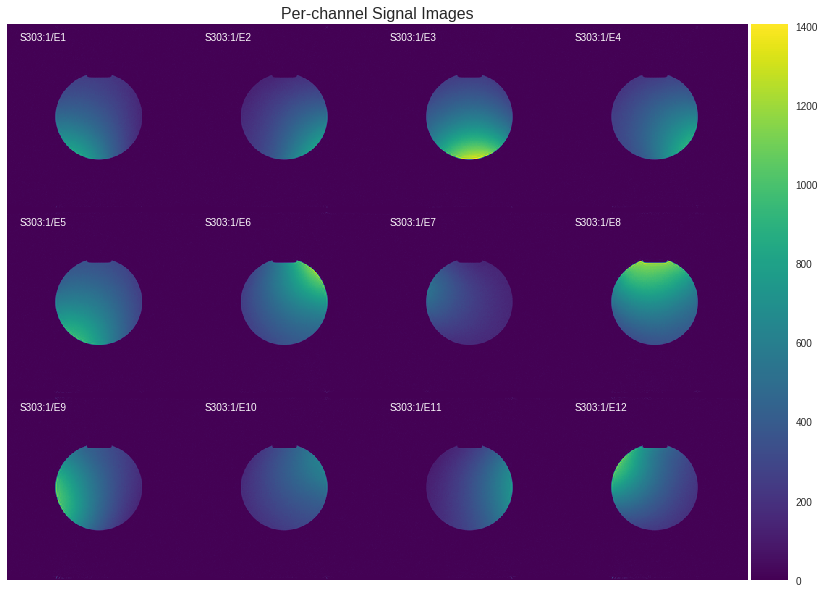

In [6]:
# Assume just one element
dobjs = fetch_series(patid, studyid, sernos=series['Signal'], imagesonly=True)
show_montage(dobjs, None, op='mean', cmap='viridis', title='Per-channel Signal Images');

In [7]:
NewPage

### Signal to Noise Ratio
The individual element images have the expected noise characteristics when combined as a sum of squares. The signal-to-noise ratio calculated in ROIs encompassing the central 50% and 75% of the phantom is consistent with previous values for this scanner.

Signal to noise ratio using uncombined signal images, which we combine here as some of squares. A current limitation is that this may only work with Siemens where we have multi-series not multi-frames.

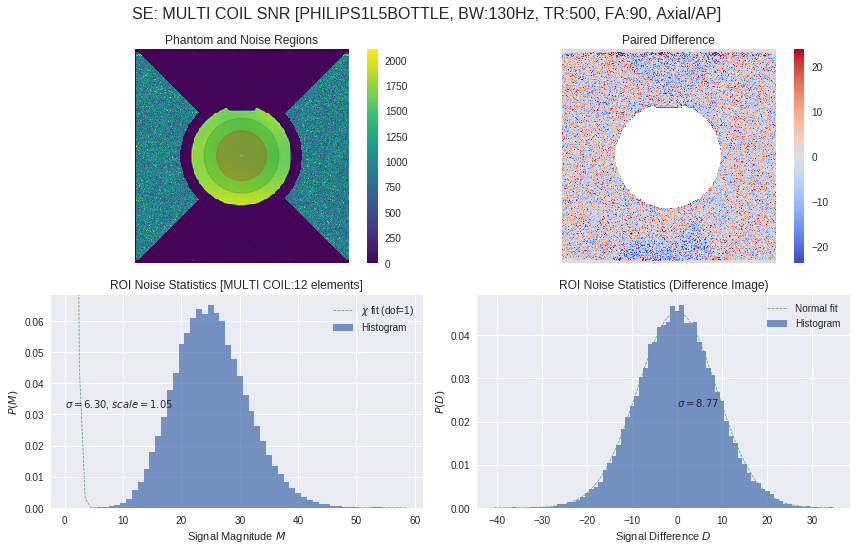

MULTI COIL
0.50  268.439007
0.75  271.228082

In [8]:
# SNR (uncombined channels)
dobjs = fetch_series(patid, studyid, sernos=series['Signal'], imagesonly=True)
snr_report_multi(dobjs, None, phantom=phantom)

----

In [9]:
NewPage

## Geometry

For geometrical measures we want to look at the average of the coil-combined images with *Prescan Normalise* intensity correction applied. This will give us the highest SNR and the most uniform image, which should make the segmentation more robust wthout affecting the image geometry.

## Phantom Circularity (Scale and Distortion)
The change in diameter of the phantom with angle is shown below. The mean diameter is within 1% of the expected value and the level of distortion is acceptable.

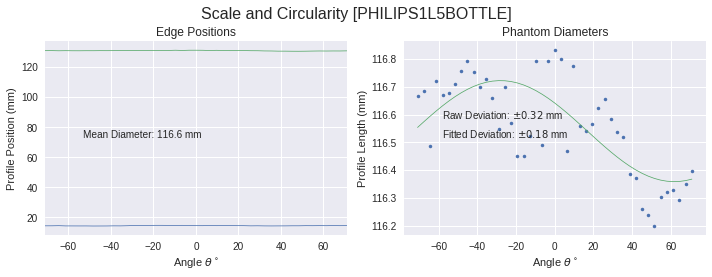

PHILIPS1L5BOTTLE
Nominal                117.000000
Diameter               116.561203
Deviation                0.316498
FittedDeviation          0.181876

In [10]:
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Geometry'], imagesonly=True),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber))
)
circularity_report(dobjs[0], phantom=phantom, excluded_sector=38).T

----

## Ghosting
Image ghosting is assessed in an axial slice imaged with a standard spin echo. The level of ghosting is negligible.

We can use the same routines for ghosting as for the small GE sphere. As the phantom is cylindrical, of course, only the axial plane will be considered.

Note that the actual values obtained for the ghosting ratio will vary somewhat according to exactly where the ghosting regions of interest are defined. In particular, any ringing-like behaviour will only be detected with a ROI close to the phantom. Nyquist ghosting on the other hand is best detected with an ROI that comprises the phantom shifted by N/2 in the *phase encoding* direction.

As the test compares background signal in the phase encoding and the readout direction we are only sensitive to these separately (generally in the phase encoding direction). Anything that is manifest on both axes will cancel out in the subtraction. Possibly a better point of comparison would be the image corners.

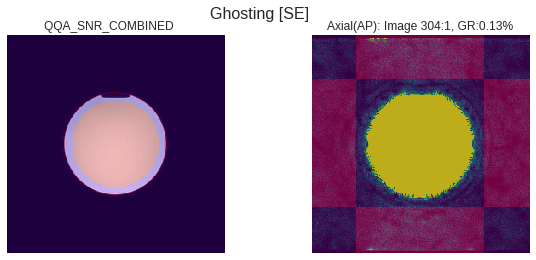

Series                    304
Protocol     QQA_SNR_COMBINED
Orientation             Axial
Sequence                   SE
GhostRatio           0.130725

In [11]:
# BOTTLE: Ghosting
dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'], imagesonly=True)
results = ghosting_report([dobjs[0]], phantom=phantom)
results[['Protocol', 'Orientation', 'Sequence', 'GhostRatio']].T

----

## Uniformity
The axial uniformity is tested in on a uniform cylinder both before and after the coil sensitivity intensity correction is applied. As expected for a multi-element coil the uncorrected image is significantly non-uniform. However, the coil sensitivity correction provides adequate compensation.

A uniform cylinder was imaged to test the uniformity. The raw image is expected to be significantly non-uniform due to the head coil sensitivity pattern. The image with prescan normalize applied should be compensated for this. Note that at 3T significant contribution from $B_1^+$ non-uniformity is expected due to the phantom size and filling material which is not so easily corrected.

The axial uniformity is acceptable for a head coil both with and without the coil sensitivity correction applied.

These are the same routines for uniformity as for the oil sphere used at acceptance but the phantom is cylindrical so only the axial plane is considered. Note that, at 3T there will be a significant contribution from the $B_1^+$ non-uniformity as well as from the receive coil sensitivities. Only some of this may be compensated for by the prescan normalize option; the scans used to calibrate this may have different sensitivity to flip angle variations. On the other hand this is quite a small phantom so the $B_1^+$ effects may not be very pronounced over such a limited volume.

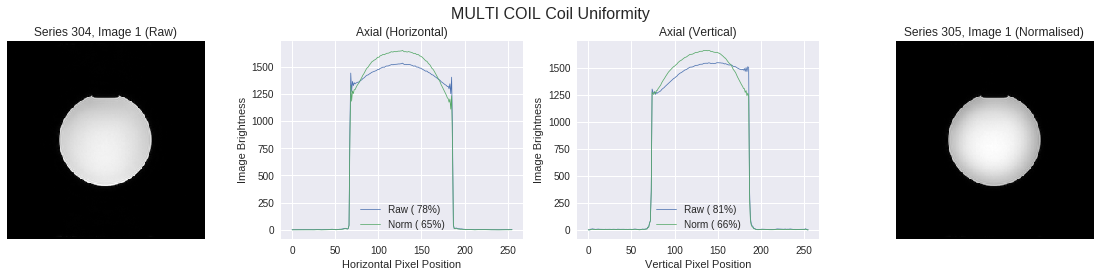

Orientation            Axial
XUniformityRaw     78.333333
YUniformityRaw     81.415929
NEMAUniformityRaw  95.328642

In [12]:
raw_dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'], imagesonly=True)
psn_dobjs = fetch_series(patid, studyid, sernos=series['Geometry'], imagesonly=True)
df = uniformity_report(raw_dobjs=raw_dobjs[:1], psn_dobjs=psn_dobjs[:1], phantom=phantom)
df[['XUniformityRaw', 'YUniformityRaw', 'NEMAUniformityRaw']].T

In [13]:
df[['XUniformityNorm', 'YUniformityNorm', 'NEMAUniformityNorm']].T

Orientation             Axial
XUniformityNorm     65.000000
YUniformityNorm     66.371681
NEMAUniformityNorm  93.027454

----

## Frequency Reference and Transmitter Voltage

These are the reference values reported in the DICOM headers.

In [14]:
# dobj = raw_dobjs[0]
# csa_tags = csa(dobj)
# phoenix_tags = phoenix(dobj)
# pd.DataFrame({
#     'ImagingFrequency': [float(dobj.ImagingFrequency)],
#     'TransmitterCalibration': [float(csa_tags['TransmitterCalibration'])],
#     'TalesReferencePower': [float(csa_tags['TalesReferencePower'])],
#     'GradientSensitivityX': [
#         float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityX']) * 1e6,
#     ],
#     'GradientSensitivityY': [
#         float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityY']) * 1e6,
#     ],
#     'GradientSensitivityZ': [
#         float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityZ']) * 1e6
#     ]
# }, index=['Value']).T

----